In [53]:
from PIL import Image
import imageio
import numpy as np
import matplotlib.pylab as plt 
%matplotlib widget

In [54]:
def read_pnm_as_np_array(file_path):
    try:
        # Read 
        # the PNM file using imageio
        image = imageio.imread(file_path)

        # Convert the image to a NumPy array
        image_array = np.array(image)

        return image_array

    except Exception as e:
        print(f"Error: {e}")
        return None



In [72]:

def read_file_to_dict(file_path):
    result_dict = {}
    
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Split each line into parameter and value using '=' as a separator
                parts = line.strip().split('=')
                
                # Make sure there are two parts in the line
                if len(parts) == 2:
                    parameter, value = parts
                    result_dict[parameter] = int(value)
    
    except Exception as e:
        print(f"Error: {e}")
    
    return result_dict

In [70]:
def calculate_time_per_row(header):

    # this function provides some useful timing data for the CCD readout

    # Note that minor "transition" states may have been omitted resulting in
    # somewhat shorter readout times (<0.1%).

    # Default timing setting is_
    # ccd_r_timing <= x"A4030206141D"&x"010303090313"

    # All pixel timing setting is the final count of a counter that starts at 0,
    # so the number of clock cycles exceeds the setting by 1

    # image parameters
    ncol = int(header["NCOL"]) + 1
    ncolbinC = 0 #int(header["NCBIN CCDColumns"])
    if ncolbinC == 0:
        ncolbinC = 1
    ncolbinF = 0 #int(header["NCBIN FPGAColumns"])

    nrow = int(header["NROW"])
    nrowbin = int(header["NRBIN"])
    if nrowbin == 0:
        nrowbin = 1
    nrowskip = int(header["NRSKIP"])

    n_flush = int(header["NFLUSH"])

    # timing settings
    full_timing = 1  # TODO <-- meaning?

    # full pixel readout timing n#TODO discuss this with OM,  LM these are default values. change these when the header contians this infromation

    time0 = 1 + 19  # x13%TODO
    time1 = 1 + 3  # x03%TODO
    time2 = 1 + 9  # x09%TODO
    time3 = 1 + 3  # x03%TODO
    time4 = 1 + 3  # x03%TODO
    time_ovl = 1 + 1  # x01%TODO

    # fast pixel readout timing
    timefast = 1 + 2  # x02%TODO
    timefastr = 1 + 3  # x03%TODO

    # row shift timing
    row_step = 1 + 164  # xA4%TODO

    clock_period = 30.517  # master clock period, ns 32.768 MHz

    # there is one extra clock cycle, effectively adding to time 0
    Time_pixel_full = (
        1 + time0 + time1 + time2 + time3 + time4 + 3 * time_ovl
    ) * clock_period

    # this is the fast timing pixel period
    Time_pixel_fast = (1 + 4 * timefast + 3 * time_ovl + timefastr) * clock_period

    # here we calculate the number of fast and slow pixels
    # NOTE: the effect of bad pixels is disregarded here

    if full_timing == 1:
        n_pixels_full = 2148
        n_pixels_fast = 0
    else:
        if ncolbinC < 2:  # no CCD binning
            n_pixels_full = ncol * ncolbinF
        else:  # there are two "slow" pixels for one superpixel to be read out
            n_pixels_full = 2 * ncol * ncolbinF
        n_pixels_fast = 2148 - n_pixels_full

    # time to read out one row
    T_row_read = n_pixels_full * Time_pixel_full + n_pixels_fast * Time_pixel_fast

    # shift time of a single row
    T_row_shift = (64 + row_step * 10) * clock_period

    # time of the exposure start delay from the start_exp signal # n_flush=1023
    T_delay = T_row_shift * n_flush

    # total time of the readout
    T_readout = T_row_read * (nrow + nrowskip + 1) + T_row_shift * (1 + nrowbin * nrow)

    # "smearing time"
    # (this is the time that any pixel collects electrons in a wrong row, during the shifting.)
    # For smearing correction, this is the "extra exposure time" for each of the rows.

    T_row_extra = (T_row_read + T_row_shift * nrowbin) / 1e9

    return T_row_extra, T_delay


# no shutter files 

1 1 5  
2063_29571_1  
2118_34049_1  
2178_18825_1  

 # with shutter files 

 1 1 7  
2936_16656_1  
3005_1274_1  
3081_53744_1  

In [55]:
nsimage=read_pnm_as_np_array('data/2118_34049_1.pnm')
nsimagedk1=read_pnm_as_np_array('data/2063_29571_1.pnm')
nsimagedk2=read_pnm_as_np_array('data/2178_18825_1.pnm')
wsimage=read_pnm_as_np_array('data/3005_1274_1.pnm')
wsimagedk1=read_pnm_as_np_array('data/2936_16656_1.pnm')
wsimagedk2=read_pnm_as_np_array('data/3081_53744_1.pnm')

/var/folders/z9/z5mq6p390ls748hn4fyfy9pw0000gn/T/ipykernel_3722/1940596922.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_path)


In [73]:
header=read_file_to_dict('data/2118_34049_1_output.txt')
print(header)
calculate_time_per_row(header)

{'id': 2118340491, 'CCDSEL': 1, 'EXPTS': 2118, 'EXPTSS': 34049, 'WDW': 7, 'WDWOV': 0, 'JPEGQ': 101, 'FRAME': 511, 'NROW': 511, 'NRBIN': 1, 'NRSKIP': 0, 'NCOL': 2047, 'NCBIN': 1, 'NCSKIP': 0, 'NFLUSH': 1023, 'TEXPMS': 5000, 'GAIN': 0, 'TEMP': 4104, 'FBINOV': 0, 'LBLNK': 301, 'TBLNK': 309, 'ZERO': 117, 'TIMING1': 5149, 'TIMING2': 518, 'VERSION': 50, 'TIMING3': 41987, 'NBC': 0}


(0.003264281422, 53509179.174)

In [56]:
nscorr = (nsimage-(nsimagedk1 + nsimagedk2)/2).T / 5
wscorr = (wsimage-(wsimagedk1 + wsimagedk2)/2).T /5

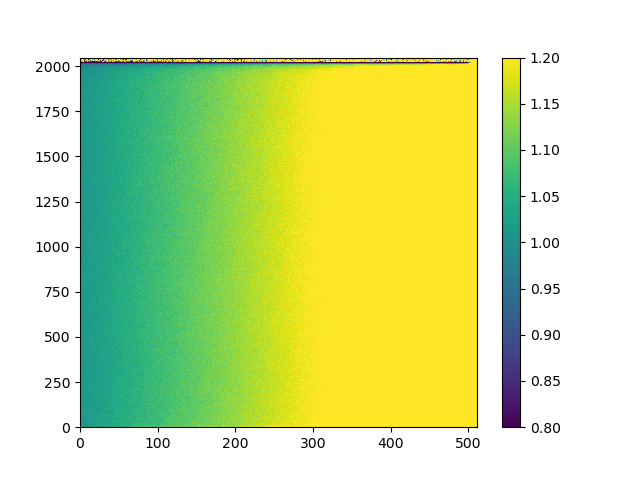

In [62]:
plt.figure()
plt.pcolor (nscorr/wscorr)
plt.clim([.8 , 1.2])
plt.colorbar()

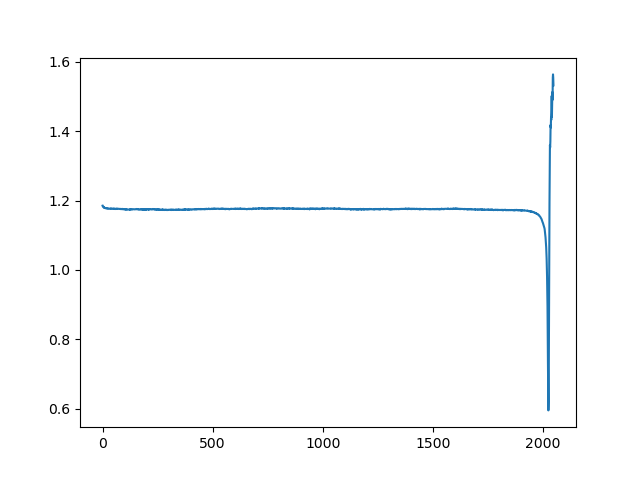

In [64]:
plt.figure()
plt.plot(nscorr.mean(axis=1)/wscorr.mean(axis=1))